In [1]:
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
from numba import jit

In [3]:
J = 1
Tc = 1/0.44068

#@jit(nopython=True)
def InitialLattice0(Nx, Ny):
    lattice = np.array(1-2*np.random.randint(0, 2, (Nx, Ny)))
    left = np.ones(Ny)
    lattice = np.insert(lattice, 0, left, axis = 0)
    lattice = np.insert(lattice, Nx+1, left, axis = 0)
    return lattice
    
# def updateLattices(lattice, treshold):
#     copy1 = copy(lattice)
#     cols, rows = np.shape(lattice)
#     Nchange = np.int(np.rint(np.random.uniform(high = treshold)*(cols-2)*rows))
#     ycoords = np.random.randint(0, rows, Nchange)
#     xcoords = np.random.randint(1, cols-1, Nchange)
#     copy1[xcoords, ycoords]*= -1
#     return copy1

def HamiltonPlus0(lattice):
    global J
    H = 0
    cols, rows = np.shape(lattice)
    for i in range(cols-1):
        H += np.inner(lattice[i], lattice[i+1])
    for i in range(rows-1):
        H += np.inner(lattice[1:-1,i], lattice[1:-1,i+1])
    H += np.inner(lattice[1:-1,0], lattice[1:-1,-1])
    return -H*J

@jit(nopython=True)
def DeltaHamilton0(lattice, x, y):
    global J
    cols, rows = np.shape(lattice)
    deltaH = lattice[x,y]*(lattice[x-1,y]+lattice[x+1,y]+lattice[x,(y+1)%(rows)]+lattice[x,(y-1)%(rows)])
    return 2*J*deltaH

@jit(nopython=True)
def W0(lattice, x, y, T):
    #deltaH = Hamiltonian(latticeAfter)-Hamiltonian(latticeBefore)
    deltaH = DeltaHamilton0(lattice, x, y)
    return np.exp(-deltaH/T)

@jit(nopython=True)
def HamiltonDiff0(column):
    global J
    deltaH = 2*np.sum(column)
    return J*deltaH

def main0(T, treshold, Nx, Ny, sweeps, subs):
    lattice = InitialLattice0(Nx, Ny)
    return MonteCarlo0(T, treshold, Nx, Ny, sweeps, lattice, subs)
    
@jit(nopython=True)
def MonteCarlo0(T, treshold, Nx, Ny, sweeps, lattice, subs):
    coords = np.array([(x, y) for y in range(Ny) for x in range(1, Nx+1)])
    Nc = len(coords)
    np.random.shuffle(coords)
    for i in range(1000):
        for j in range(Nc):
            w = W0(lattice, coords[j,0], coords[j,1], T)
            if w > np.random.uniform(0.0, 1.0):
                lattice[coords[j,0], coords[j,1]] *= -1
    Z = np.array([0])
    Z1 = 0
    Z2 = 0
    sigma1 = 100
    #H = np.array([0.0])
    count = 0
    for i in range(sweeps):
        for b in range(subs):
            Z = np.array([0])
            coords = np.array([(x, y) for y in range(Ny) for x in range(1, Nx+1)])
            np.random.shuffle(coords)
            coords = coords[:int(np.rint(Nc*np.random.uniform(0.0, 1.0)))]
            for j in range(len(coords)):
                w = W0(lattice, coords[j,0], coords[j,1], T)
                if w > np.random.uniform(0.0, 1.0):
                    lattice[coords[j,0], coords[j,1]] *= -1
                #Z = np.append(Z, Z[-1] + np.exp(-1*HamiltonDiff(lattice[-2])/T))
            Z[b] = np.exp(-1*HamiltonDiff0(lattice[-2])/T)
        sigma = np.std(Z)
        Z2 += np.mean(Z)
        if sigma < sigma1:
            sigma1 = sigma
            z1 = np.mean(Z)
    return z1, Z1/subs #lattice #Z1/count #, Z1 #/sweeps

In [2]:
J = 1
Tc = 1/0.44068

#@jit(nopython=True)
def InitialLattice(Nx, Ny):
    lattice = np.array(1-2*np.random.randint(0, 2, (Nx, Ny)), dtype = np.float64)
    return lattice

@jit(nopython=True)
def HamiltonPlus(lattice, Nx, Ny):
    global J
    H = 0
    for i in range(Nx-1):
        H += np.sum(lattice[i]*lattice[i+1])
    for i in range(Ny-1):
        H += np.sum(lattice[:,i]*lattice[:,i+1])
    H += np.sum(lattice[:,0]*lattice[:,-1])
    H += np.sum(lattice[0,:]*lattice[-1,:])
    return -H*J

@jit(nopython=True)
def DeltaHamilton(lattice, x, y, W, Nx, Ny, T):
    #global WT
    deltaH = lattice[x,y]*(lattice[x-1,y]+lattice[(x+1)%(Nx-1),y]+lattice[x,(y+1)%Ny]+lattice[x,y-1])
    return  W[int(2+deltaH/2)] #, np.exp(-2*deltaH/T) 

# @jit(nopython=True)
# def W(lattice, x, y, T):
#     global WT
#     #deltaH = Hamiltonian(latticeAfter)-Hamiltonian(latticeBefore)
#     deltaH = DeltaHamilton(lattice, x, y)
#     return np.exp(-deltaH/T)

@jit(nopython=True)
def HamiltonDiff(columnLeft, columnRight):
    global J
    deltaH = np.sum(columnLeft*columnRight) + np.sum(columnLeft*columnRight[::-1])
    #deltaH = np.dot(columnLeft, columnRight) - np.dot(columnLeft, columnRight[::-1])
    return J*deltaH

@jit(nopython=True)
def HamiltonDiff1(lattice, Nx, Ny, T):
    global J
    deltaH = 0
    for i in range(Nx):
        deltaH += np.exp(-1*(np.sum(lattice[i]*lattice[(i+1)%Nx]) + np.sum(lattice[i]*lattice[(i+1)%Nx][::-1]))/T)
    for i in range(Ny):
        deltaH += np.exp(-1*(np.sum(lattice[:,i]*lattice[:,(i+1)%Ny]) + np.sum(lattice[:,i]*lattice[:,(i+1)%Ny][::-1]))/T)
    return deltaH/(Nx+Ny)

#     latt1 = np.roll(lattice, 1, axis = 1)
#     torus = latt1*lattice
#     latt2 = np.flipud(latt1)
#     klein = lattice*latt2
#     prod = np.sum(torus) + np.sum(klein)
    
#    return J*prod/Nx

def main(T, treshold, Nx, Ny, sweeps, start, subs):
    global J
    W = np.exp(-1*np.array([-8, -4, 0, 4, 8])*J/T)
    lattice = InitialLattice(Nx, Ny)
    return MonteCarlo(T, treshold, Nx, Ny, sweeps, lattice, W, start, subs)
    
@jit(nopython=True)
def MonteCarlo(T, treshold, Nx, Ny, sweeps, lattice, W, start, subs):
    coords = np.array([(x, y) for y in range(Ny) for x in range(Nx)])
    Nc = len(coords)
    np.random.shuffle(coords)
    for i in range(start):
        for j in range(Nc):
            #w1, w2 = W0(lattice, coords[j,0], coords[j,1], T)
            w = DeltaHamilton(lattice, coords[j,0], coords[j,1], W, Nx, Ny, T)
            if w > np.random.uniform(0.0, 1.0):
                lattice[coords[j,0], coords[j,1]] *= -1
    #Z = np.zeros(subs)
    Z1 = 0
    Z2 = 0
    sigma1 = 100
    #H = np.zeros(sweeps)
    
    for i in range(sweeps):
        Z = np.zeros(subs)
        for b in range(subs):
            coords = np.array([(x, y) for y in range(Ny) for x in range(Nx)])
            np.random.shuffle(coords)
            coords = coords[:int(np.rint(Nc*np.random.uniform(0.0, 1.0)))]
            for j in range(Nc):
                w = DeltaHamilton(lattice, coords[j,0], coords[j,1], W, Nx, Ny, T)
                if w > np.random.uniform(0.0, 1.0):
                    lattice[coords[j,0], coords[j,1]] *= -1
            Z[b] = HamiltonDiff1(lattice, Nx, Ny, T)
        sigma = np.std(Z)
        if sigma < sigma1:
            Z1 = np.mean(Z)
            sigma1 = sigma
        Z2 += np.mean(Z)
        #Z1 += HamiltonDiff1(lattice, Nx, Ny, T)
        #Z1 += np.exp(-1*HamiltonDiff(lattice[0], lattice[-1])/T)
    return Z1, Z2/sweeps, sigma1 #/sweeps #Z1/count #, lattice #Z1/count #, Z1 #/sweeps

In [67]:
#TEMP1 = main(0.75*Tc, treshold, 8, 8, sweeps, start, 20*subs)
#TEMP2 = main(0.8*Tc, treshold, 16, 16, sweeps, start, 40*subs)
# TEMP3 = main(0.85*Tc, treshold, 10, 10, sweeps, start, 30*subs)
TEMP4 = main(0.85*Tc, treshold, 4, 4, sweeps, start, 1000*subs)


KeyboardInterrupt: 

In [ ]:
N07 =  np.array([4, 6, 8, 10, 16])

In [66]:
#master05[:,1][2] = TEMP1[1]
#master03[:,1][-1] = TEMP2[1]
master04[:,1][0] = TEMP4[1]



In [18]:
sweeps = 50
start = 5000
subs = 2000

N06 =  np.array([4, 6, 8, 10, 12, 16])

treshold = 0.3
Nx, Ny = 12, 12
#N06 = np.array([8, 22, 32, 46, 64])
n = len(N06)
master0005 = np.zeros([n,3])
for i in range(n):
    print(i)
    master0005[i] = main(0.005*Tc, treshold, N06[i], N06[i], sweeps, start, subs)

0
1
2
3
4
5


In [125]:
a = np.append(-0.9*Tc/N06[:-1]*np.log(master12[:,1][:-1])/0.1, -0.95*Tc/N06[:-1]*np.log(master42[:,1][:-1])/0.05)
a = np.append(a, -0.97*Tc/N06[:-1]*np.log(master52[:,1][:-1])/0.03)
b = np.append(1/(N06[:-1]*0.1), 1/(N06[:-1]*0.05))
b = np.append(b, 1/(N06[:-1]*0.03))

In [127]:
dim = np.vstack([ b, np.ones(len(b))]).T
alpha, beta = np.linalg.lstsq(dim, a, rcond=None)[0]

In [131]:
regx = np.linspace(1, 8, 100)
regy = alpha*regx + beta

In [20]:
%matplotlib notebook

In [22]:
print(-0.005*Tc/N06*np.log(master0005[:,0])/0.995)

[2.01005025        inf        inf        inf        inf        inf]


C:\Users\Fredrik Knapskog\Documents\Anakonda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


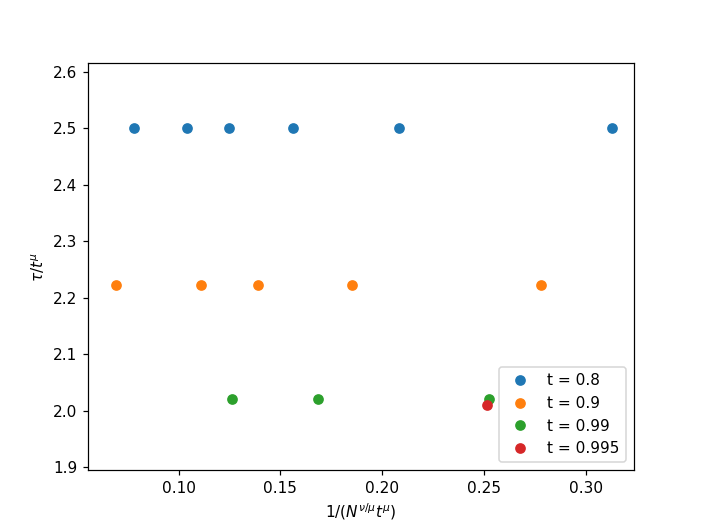

C:\Users\Fredrik Knapskog\Documents\Anakonda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Fredrik Knapskog\Documents\Anakonda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Fredrik Knapskog\Documents\Anakonda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [21]:
# plt.plot(1/(8*t8), -ts8/8*np.log(master8[:,1])/t8, 'bo', label = "N=8")
plt.plot(1/(N06*0.8), -0.2*Tc/N06*np.log(master02[:,0])/0.8, 'o', label = "t = 0.8")
plt.plot(1/(N06*0.9), -0.1*Tc/N06*np.log(master01[:,0])/0.9, 'o', label = "t = 0.9")
plt.plot(1/(N06*0.99), -0.01*Tc/N06*np.log(master001[:,0])/0.99, 'o', label = "t = 0.99")
plt.plot(1/(N06*0.995), -0.005*Tc/N06*np.log(master0005[:,0])/0.995, 'o', label = "t = 0.995")


# plt.plot(1/(N06*0.25), -0.75*Tc/N06*np.log(master05[:,1])/0.25, 'yo', label = "t = 0.25")
# plt.plot(1/(N06*0.2), -0.8*Tc/N06*np.log(master03[:,1])/0.2, 'ro', label = "t = 0.2")
# plt.plot(1/(N06*0.15), -0.85*Tc/N06*np.log(master04[:,1])/0.15, 'go', label = "t = 0.15")

plt.ylabel(r"$\tau / t^\mu$")
plt.xlabel(r"1/($N^{\nu/\mu} t^\mu$)")

# plt.plot(1/(16*t), -ts/16*np.log(master16[:,1])/t, label = "N=16v")
plt.vlines(0, 1, 3)
#plt.hlines(3.99, 0, 0.75)
plt.legend(loc = 4)

<IPython.core.display.Javascript object>


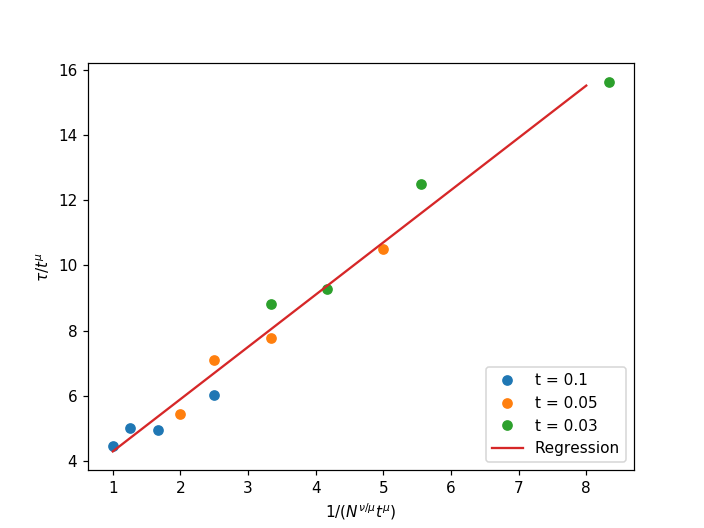

Text(0.5, 0, '1/($N^{\\nu/\\mu} t^\\mu$)')

In [132]:
plt.plot(1/(N06[:-1]*0.1), -0.9*Tc/N06[:-1]*np.log(master12[:,1][:-1])/0.1, 'o', label = "t = 0.1")
plt.plot(1/(N06[:-1]*0.05), -0.95*Tc/N06[:-1]*np.log(master42[:,1][:-1])/0.05, 'o', label = "t = 0.05")
plt.plot(1/(N06[:-1]*0.03), -0.97*Tc/N06[:-1]*np.log(master52[:,1][:-1])/0.03, 'o', label = "t = 0.03")
plt.plot(regx, regy, label = "Regression")
plt.legend(loc = 4)
plt.ylabel(r"$\tau / t^\mu$")
plt.xlabel(r"1/($N^{\nu/\mu} t^\mu$)")
# plt.plot(1/(N06*0.2), -0.8*Tc/N06*np.log(master22[:,1])/0.2, 'o', label = "t = 0.2")
# plt.plot(1/(N06*0.3), -0.7*Tc/N06*np.log(master32[:,1])/0.3, 'o', label = "t = 0.3")

In [83]:
dim = np.vstack([ 1/(0.5*N06[2:]), np.ones(len(N06[2:]))]).T
alpha, beta = np.linalg.lstsq(dim, -0.5*Tc/N06[2:]*np.log(master61[:,0][2:])/0.5, rcond=None)[0]

In [84]:
alpha, beta

(-0.03502228384445209, 3.7961015935240985)

In [113]:
# plt.plot(1/(8*t8), -ts8/8*np.log(master8[:,1])/t8, 'bo', label = "N=8")
plt.plot(1/(N06*0.3), -0.7*Tc/N06*np.log(master02[:,0])/0.3, 'bo', label = "t = 0.3")
plt.plot(1/(N06*0.25), -0.75*Tc/N06*np.log(master05[:,0])/0.25, 'yo', label = "t = 0.25")
plt.plot(1/(N06*0.2), -0.8*Tc/N06*np.log(master03[:,0])/0.2, 'ro', label = "t = 0.2")
plt.plot(1/(N06*0.15), -0.85*Tc/N06*np.log(master04[:,0])/0.15, 'go', label = "t = 0.15")
#plt.plot(1/(10*0.15), -0.85*Tc/10*np.log(TEMP3[1])/0.15, 'ko')

# plt.plot(1/(N06*0.3), -0.7*Tc/N06*np.log(master07[:,-1])/0.3, 'ro', label = "t = 0.9")
# plt.plot(1/(N06*0.2), -0.8*Tc/N06*np.log(master08[:,-1])/0.2, 'go', label = "t = 0.9")

# plt.plot(1/(8*t[7]), -ts[7]/8*np.log(TEMPE[1])/t[7], 'ro', label = "N=8")
# # plt.show()
# #plt.plot(1/(8*t[:-1]), -ts[:-1]/8*np.log(master8[:,1])/t[:-1], 'ro', label = "N=8")
# # plt.plot(1/(16*t), -ts/16*np.log(master16[:,1])/t, 'ro', label = "N=16")
# plt.plot(1/(16*t16), -ts16/16*np.log(master161)/t16, 'ro', label = "N=16")

# # plt.plot(1/(32*t), -ts/32*np.log(master32[:,2])/t, 'go', label = "N=16")
# # plt.plot(1/(12*t12), -ts12/12*np.log(master12[:,1])/t12, 'go', label = "N=12")
# plt.plot(1/(12*t12), -ts12/12*np.log(master121)/t12, 'go', label = "N=12")
plt.ylabel(r"$\tau / t^\mu$")
plt.xlabel(r"1/($N^{\nu/\mu} t^\mu$)")

# plt.plot(1/(16*t), -ts/16*np.log(master16[:,1])/t, label = "N=16v")
plt.vlines(0, 2, 5)
plt.hlines(3.99, 0, 1.75)
plt.legend(loc = 4)

C:\Users\Fredrik Knapskog\Documents\Anakonda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: operands could not be broadcast together with shapes (5,) (15,) 

In [160]:
sweeps = 200
start = 25000
subs = 10000

treshold = 0.5
Nx, Ny = 8, 8
ts = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8])*Tc
n = len(ts)
master8 = np.zeros([n,3])
for i in range(n):
    print(i)
    master8[i] = main(ts[i], treshold, Nx, Ny, sweeps, start, subs)

0
1
2
3
4
5
6
7
8


In [193]:
sweeps = 300
start = 10000
subs = 20000
Ttemp = 0.83*Tc
treshold = 0.5
Nx, Ny = 12, 12
TEMPE1 = main(Ttemp, treshold, Nx, Ny, sweeps, start, subs)
#ts = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8])*Tc


In [128]:
dim = np.vstack([ 1/(8*t[6:-1]), np.ones(3)]).T
alpha, beta = np.linalg.lstsq(dim, -ts[6:-1]/8*np.log(master8[:,1][6:])/t[6:-1], rcond=None)[0]

In [307]:
print(master01)

[[4.88887144e-16 4.88887144e-16 6.50810247e-30]
 [1.08096822e-23 1.08096822e-23 1.57222369e-37]
 [2.39010640e-31 2.39010640e-31 2.62743462e-46]
 [5.28471466e-39 5.28471466e-39 9.46169148e-53]
 [1.16849229e-46 1.19468243e-46 3.11150764e-61]
 [2.58362906e-54 2.60844698e-54 5.65074375e-68]
 [5.71260859e-62 5.80863877e-62 6.73621147e-76]]


In [312]:
%matplotlib notebook

<IPython.core.display.Javascript object>


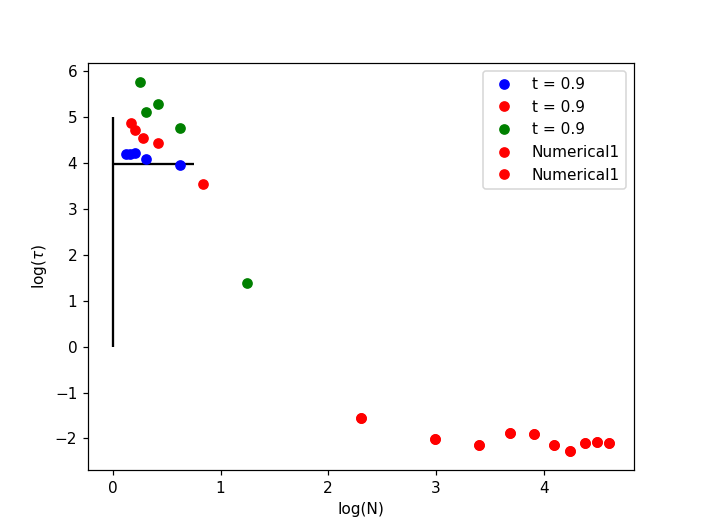

In [339]:
# plt.plot(1/(8*t8), -ts8/8*np.log(master8[:,1])/t8, 'bo', label = "N=8")
plt.plot(1/(N06*0.4), -0.6*Tc/N06*np.log(master06[:,-1])/0.4, 'bo', label = "t = 0.9")
plt.plot(1/(N06*0.3), -0.7*Tc/N06*np.log(master07[:,-1])/0.3, 'ro', label = "t = 0.9")
plt.plot(1/(N06*0.2), -0.8*Tc/N06*np.log(master08[:,-1])/0.2, 'go', label = "t = 0.9")

# plt.plot(1/(8*t[7]), -ts[7]/8*np.log(TEMPE[1])/t[7], 'ro', label = "N=8")
# # plt.show()
# #plt.plot(1/(8*t[:-1]), -ts[:-1]/8*np.log(master8[:,1])/t[:-1], 'ro', label = "N=8")
# # plt.plot(1/(16*t), -ts/16*np.log(master16[:,1])/t, 'ro', label = "N=16")
# plt.plot(1/(16*t16), -ts16/16*np.log(master161)/t16, 'ro', label = "N=16")

# # plt.plot(1/(32*t), -ts/32*np.log(master32[:,2])/t, 'go', label = "N=16")
# # plt.plot(1/(12*t12), -ts12/12*np.log(master12[:,1])/t12, 'go', label = "N=12")
# plt.plot(1/(12*t12), -ts12/12*np.log(master121)/t12, 'go', label = "N=12")
plt.ylabel(r"$\tau / t^\mu$")
plt.xlabel(r"1/($N^{\nu/\mu} t^\mu$)")

# plt.plot(1/(16*t), -ts/16*np.log(master16[:,1])/t, label = "N=16v")
plt.vlines(0, 0, 5)
plt.hlines(3.99, 0, 0.75)
plt.legend(loc = 4)

In [26]:
#Kjør denne i natt
sweeps = 200
start = 1000
subsweeps = 5000
T = Tc
treshold = 0.5
N8 = np.array([8, 10, 12, 14, 16, 18, 20, 22, 24], dtype = np.int64)
n = len(N8)
Z8 = np.zeros(n)
Z81 = np.zeros(n)
sigma8 = np.zeros(n)
for i in range(n):
    print(i)
    Z8[i], Z81[i], sigma8[i] =  main(T, treshold, N8[i], N8[i], sweeps, start, subsweeps)

0
1
2
3
4
5
6
7
8


<IPython.core.display.Javascript object>


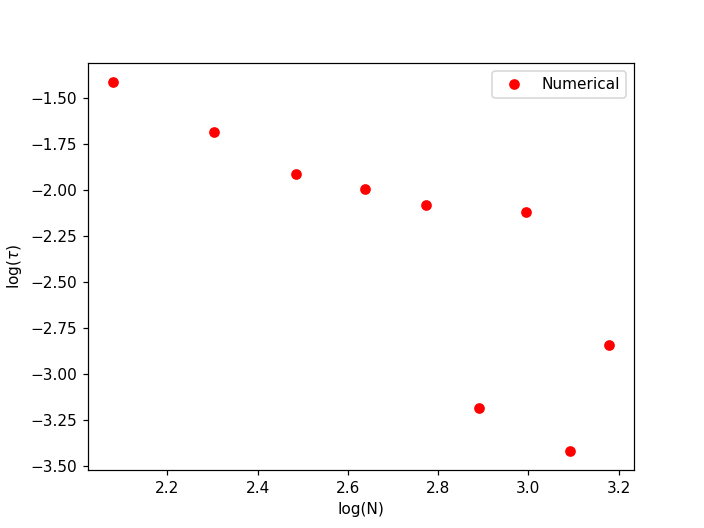

In [29]:
# plt.plot(np.log(N6), np.log(-T/N6*np.log(Z6)), 'bo', label = "Numerical")
# plt.plot(np.log(N8), np.log(-T/N6*np.log(Z61[:-3])), 'bo', label = "Numerical2")
plt.plot(np.log(N8), np.log(-T/N8*np.log(Z81)), 'ro', label = "Numerical")
#plt.plot(np.log(N8), np.log(-T/N8*np.log(Z81)), 'ro', label = "Numerical")



plt.xlabel("log(N)")
plt.ylabel(r"log($\tau$)")
# plt.plot(N, T5, label = "Analytical")
#plt.plot(2.77, -1.72, 'ro')
#plt.plot(N, alpha*N + beta, label = "Regression")
plt.legend()

In [200]:
dim = np.vstack([ np.log(N6), np.ones(len(N6))]).T
alpha, beta = np.linalg.lstsq(dim, np.log(-T/N6*np.log(Z61)), rcond=None)[0]

NameError: name 'Z61' is not defined

<IPython.core.display.Javascript object>


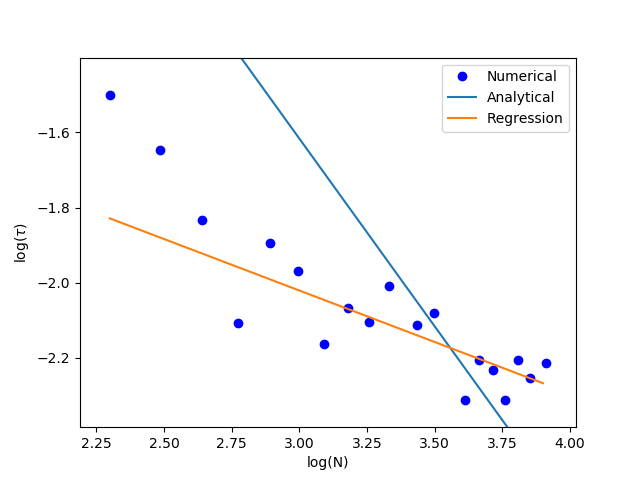

In [413]:
plt.plot(np.log(N2), np.log(-Tc/N2*np.log(Z2)), 'bo', label = "Numerical")
plt.xlabel("log(N)")
plt.ylabel(r"log($\tau$)")
plt.plot(N, T5, label = "Analytical")
plt.plot(N, alpha*N + beta, label = "Regression")
plt.legend()

In [368]:
#N = np.linspace(np.log(N2[0]), np.log(N2[-1]), 100)
N = np.linspace(2, 3.5, 100)

T5 = -N + np.log(3.99)

<IPython.core.display.Javascript object>


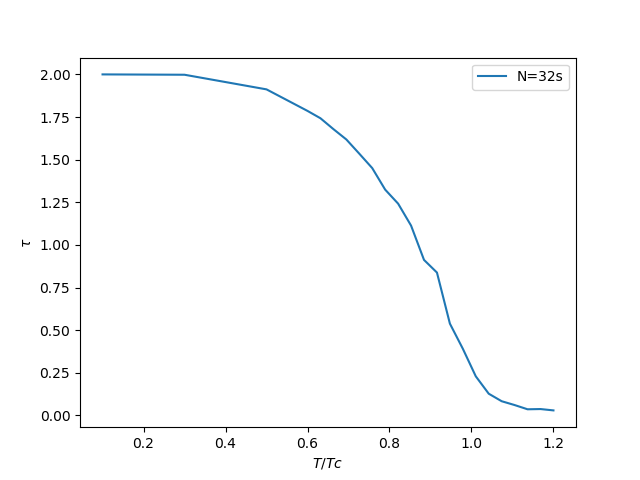

In [443]:
# #plt.plot(t/Tc, -t/64*np.log(tension), label = "N=64")
# plt.plot(t/Tc, -t/16*np.log(tension2), label = "N=16")
#plt.plot(ts/Tc, -ts/32*np.log(tension6s), label = "N=32s")
plt.plot(ts/Tc, -ts/32*np.log(tension6ss), label = "N=32s")
plt.xlabel(r"$T/Tc$")
plt.ylabel(r"$\tau$")
# plt.plot(ts/Tc, -ts/128*np.log(tension3s), label = "N=128s")
# plt.plot(ts/Tc, -ts/16*np.log(tension4s), label = "N=16s")
# plt.plot(ts/Tc, -ts/64*np.log(tension5s), label = "N=64s")

plt.legend()

In [23]:
sweeps = 20
start = 500
subs = 200
n = 20
treshold = 0.5
Nx, Ny = 128, 128
tcompare = np.append(np.linspace(0.2, 0.5, 3), np.linspace(0.6, 1.2, n))*Tc
torus8 = np.zeros([n+3, 3])
for i in range(n+3):
    print(i)
    torus8[i] = main(tcompare[i], treshold, Nx, Ny, sweeps, start, subs)

0
1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

C:\Users\Fredrik Knapskog\Documents\Anakonda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


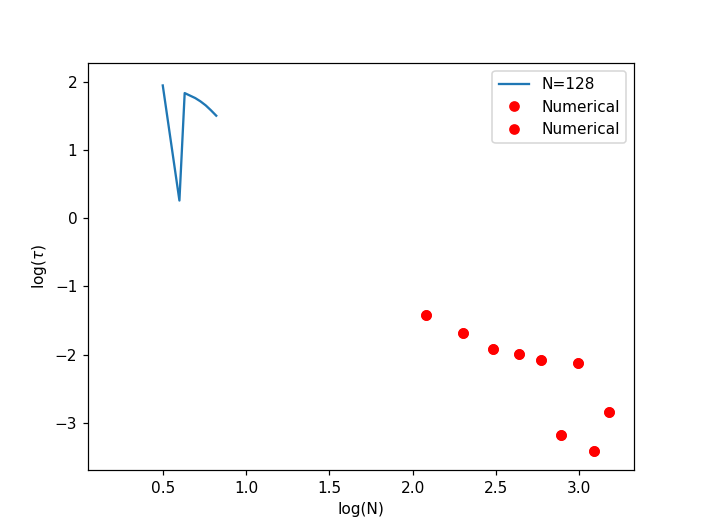

Text(0, 0.5, '$\\tau$')

In [25]:
#plt.plot(TA/Tc, analytic)
# plt.plot(t128/Tc, -t128/128*np.log(tau1281), label = "N=128")
# plt.plot(t/Tc, -t/64*np.log(tau64), label = "N=64")
# plt.plot(t/Tc, -t/32*np.log(tau32), label = "N=32")
# plt.plot(t/Tc, -t/16*np.log(tau8), label = "N=16")
# plt.plot(tcompare/Tc, -tcompare/8*np.log(torus12[:,0]), label = "N=8")
# plt.plot(tcompare/Tc, -tcompare/16*np.log(torus16[:,0]), label = "N=16")
# # plt.plot(tcompare/Tc, -tcompare/24*np.log(torus24[:,0]), label = "N=24")
# plt.plot(tcompare/Tc, -tcompare/32*np.log(torus32[:,0]), label = "N=32")
# plt.plot(tcompare/Tc, -tcompare/64*np.log(torus64[:,0]), label = "N=64")
plt.plot(tcompare[:11]/Tc, -tcompare[:11]/128*np.log(torus8[:,0][:11]), label = "N=128")





plt.legend()
#plt.plot((0.8, 0.8), (1.458, 1.354), 'ro')
# plt.xlim(0.3, 1.2)
# plt.ylim(0, 2.3)
#plt.hlines(0, 0, 1.2)
plt.xlabel(r"$T/Tc$")
plt.ylabel(r"$\tau$")

In [139]:
alpha, beta

(1.6070215511050279, 2.675144432289455)

In [7]:
%matplotlib notebook

In [4]:
sweeps = 20
start = 5000
subs = 2000
n = 20
treshold = 0.5
Nx, Ny = 12, 12
#tcompare = np.append(np.linspace(0.2, 0.5, 3), np.linspace(0.6, 1.2, n))*Tc
torus = np.zeros([n+3, 3])
for i in range(n+3):
    print(i)
    torus[i] = main(tcompare[i], treshold, Nx, Ny, sweeps, start, subs)

0


NameError: name 'main' is not defined

In [ ]:
sweeps = 20
start = 5000
subs = 20000
n = 20
treshold = 0.5
Nx, Ny = 12, 12
tcompare = np.append(np.linspace(0.2, 0.5, 3), np.linspace(0.6, 1.2, n))*Tc
plusses1 = np.zeros([n+3, 2])
for i in range(n+3):
    print(i)
    plusses1[i] = main0(tcompare[i], treshold, Nx, Ny, sweeps, subs)

0


In [363]:
n = 20
tcompare1 = np.append(np.linspace(0.2, 0.5, 3), np.linspace(0.6, 1.2, n))*Tc

In [214]:
np.where(tcompare/Tc > 1.02)
extended = np.append(torus[:,0][:17], torus[:,1][17:])

In [264]:
%matplotlib notebook

<IPython.core.display.Javascript object>


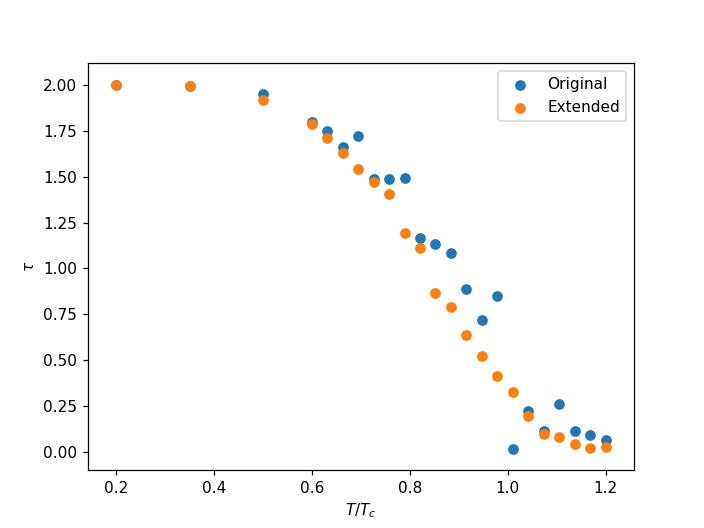

Text(0, 0.5, '$\\tau$')

In [78]:
# plt.scatter(tcompare/Tc, -tcompare/16*np.log(torus[:,0]))
# plt.scatter(tcompare/Tc, np.abs(-tcompare/16*np.log(torus[:,1])), label = "babel")
#plt.scatter(tcompare1/Tc, np.abs(-tcompare1/16*np.log(extended)), label = "Extended")
#plt.scatter(tcompare/Tc, -tcompare/16*np.log(plusses[:,0]))
plt.scatter(tcompare/Tc, np.abs(-tcompare/12*np.log(plusses[:,1])), label = "Original")
plt.scatter(tcompare/Tc, np.abs(-tcompare/12*np.log(torus[:,0])), label = "Extended")

# plt.scatter(tcompare/Tc, -np.log(plusses[:,1]))

plt.legend()
plt.xlabel(r"$T/T_c$")
plt.ylabel(r"$\tau$")

In [ ]:
TEMP = main(Tc, treshold, 20, 20, 500, 1000, 5000)

In [62]:
TEMP = main0(Tc, treshold, 10, 10, 1000000)

In [63]:
master01[4, 1] = TEMP[1]

In [53]:
%matplotlib notebook

In [ ]:
master009 = copy(master09[:,1][:-1]))
master009 = np.insert(master009, 5, TEMP[1])

In [65]:
sweeps = 500
start = 1000
subsweeps = 5000

N01 =  np.array([4, 8, 12, 16, 20, 24])
N02 =  np.array([2, 4, 6, 8, 10, 12])


treshold = 0.5
#Nx, Ny = 12, 12
#N06 = np.array([8, 22, 32, 46, 64])
n = len(N02)
master02 = np.zeros([n,3])
for i in range(n):
    print(i)
    master02[i] = main(Tc, treshold, N02[i], N02[i], sweeps, start, subsweeps)

0
1
2
3
4
5


<IPython.core.display.Javascript object>


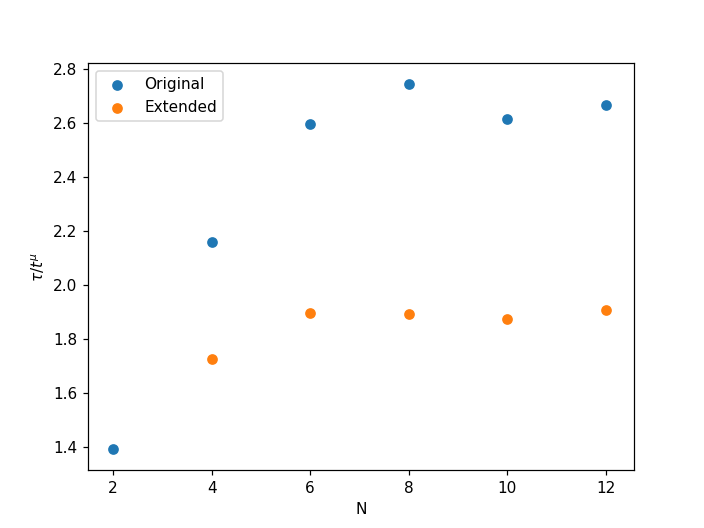

In [67]:
# plt.scatter(N01, -0.7*Tc*np.log(master09[:,1]), label = "Extended")
#plt.scatter(N01[:-1], -Tc*np.log(master09[:,1][:-1]), label = "Extended")
plt.scatter(N02, -Tc*np.log(master01[:,1]), label = "Original")
plt.scatter(N02[1:], -Tc*np.log(master02[:,1][1:]), label = "Extended")
plt.xlabel("N")
plt.ylabel(r"$\tau$/$t^\mu$")
plt.legend()